In [4]:
import numpy as np
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import matplotlib.pyplot as plt
import basis_set_exchange as bse
angstrom = 1 / 0.52917721067

mol = pyscf.gto.Mole()
mol.atom = 'N 0 0 0.; N 0 0 1.'
mol.basis = {'N': bse.get_basis('6-31G', 'N', fmt='nwchem')}
mol.verbose = 0
mol.build()

deltaZ = np.array((0.05,0.05))
includeonly = [0, 1]

calc = pyscf.scf.RHF(mol)

mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()/angstrom, deltaZ)
class NoSelfQMMM(mf.__class__):
    def energy_nuc(self):
        q = mol.atom_charges().astype(np.float)
        q[includeonly] += deltaZ
        return mol.energy_nuc(q)
mf = NoSelfQMMM()

hfe=mf.kernel(verbose=0)
mycc = pyscf.cc.CCSD(mf).run()
dm1 = mycc.make_rdm1()
dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff, dm1, mf.mo_coeff.conj())

# GRIDLESS, as things should be ############################
# Total energy of SCF run
print ('TOTAL_ENERGY', mycc.e_tot)

# Electronic EPN from electron density
for site in includeonly:
    mol.set_rinv_orig_(mol.atom_coords()[site])
    print ('ELECTRONIC_EPN', site, np.matmul(dm1_ao, mol.intor('int1e_rinv')).trace())

# Electronic Dipole w.r.t to center of geometry
with mol.with_common_orig(mol.atom_coords().mean(axis=0)):
    ao_dip = mol.intor_symmetric('int1e_r', comp=3)
dipole = numpy.einsum('xij,ji->x', ao_dip, dm1_ao).real
print ('ELECTRONIC_DIPOLE', *dipole)

# GRID, as things were #####################################
grid = pyscf.dft.gen_grid.Grids(mol)
grid.level = 3
grid.build()
ao_value = pyscf.dft.numint.eval_ao(mol, grid.coords, deriv=0)
rho = pyscf.dft.numint.eval_rho(mol, ao_value, dm1_ao, xctype='LDA')

# Ionic Forces
for site in includeonly:
    rvec = grid.coords - mol.atom_coords()[site]
    force = [(rho*grid.weights * rvec[:, _] / np.linalg.norm(rvec, axis=1)**3).sum() for _ in range(3)]
    print ('IONIC_FORCE', site, *force)

# Quadrupole moments
rs = grid.coords - mol.atom_coords().mean(axis=0)
ds = np.linalg.norm(rs, axis=1)**2
#Q = np.zeros((3,3))
for i in range(3):
    for j in range(i, 3):
        q = 3*rs[:, i]*rs[:, j]
        if i == j:
            q -= ds
        print ('ELECTRONIC_QUADRUPOLE', i, j, (rho * q * grid.weights).sum())

TOTAL_ENERGY -110.87228414355512
ELECTRONIC_EPN 0 22.05821306726308
ELECTRONIC_EPN 1 22.058213067243333
ELECTRONIC_DIPOLE -1.0216068762760736e-16 5.107565601205023e-16 -2.8524668738150183e-11
IONIC_FORCE 0 -3.4775784682472555e-16 2.345129299086146e-16 1.6506560952444391
IONIC_FORCE 1 4.0549161250957866e-16 -4.731458280726741e-16 -1.6506560953390026
ELECTRONIC_QUADRUPOLE 0 0 -14.394307823742592
ELECTRONIC_QUADRUPOLE 0 1 5.759281940243e-16
ELECTRONIC_QUADRUPOLE 0 2 2.8796409701215e-16
ELECTRONIC_QUADRUPOLE 1 1 -14.394307823742594
ELECTRONIC_QUADRUPOLE 1 2 8.049116928532385e-16
ELECTRONIC_QUADRUPOLE 2 2 28.788615647485184


In [23]:
# grid comparison
def get_grid(mol):
    grid = pyscf.dft.gen_grid.Grids(mol)
    grid.level = 3
    grid.build()
    return grid.coords, grid.weights
gridcoords, gridweights = get_grid(mol)

In [24]:
ao_value = pyscf.dft.numint.eval_ao(mol, gridcoords, deriv=0)

In [25]:
rho = pyscf.dft.numint.eval_rho(mol, ao_value, dm1_ao, xctype='LDA')

In [30]:
def epn_grid(gridcoords, gridweights, rho, mol):
    for site in range(2):
        ds = np.linalg.norm(gridcoords - mol.atom_coords()[site], axis=1)
        print ((rho * gridweights/ds).sum())
epn_grid(gridcoords, gridweights, rho,mol)

22.058212704965612
22.058212704945873


In [37]:
def force_grid(gridcoords, gridweights, rho, mol):
    for site in range(2):
        rvec = gridcoords - mol.atom_coords()[site]
        print ([(rho*gridweights * rvec[:, _] / np.linalg.norm(rvec, axis=1)**3).sum() for _ in range(3)])
force_grid(gridcoords, gridweights, rho,mol)

[1.1779856604055006e-16, 1.5157146371347352e-16, 1.6506560950760947]
[-1.9125326322644298e-16, -5.314759049523943e-16, -1.6506560951706524]


In [79]:
def dipole_grid(gridcoords, gridweights, rho, mol):
    rvec = gridcoords - mol.atom_coords().mean(axis=0)
    print ([(rho*gridweights*rvec[:, _]).sum() for _ in range(3)])
dipole_grid(gridcoords, gridweights, rho, mol)

[-4.7704895589362195e-17, 1.7867651802561113e-16, -2.850253366659672e-11]


In [78]:
def dipole_dm(mol, dm):
    with mol.with_common_orig(mol.atom_coords().mean(axis=0)):
        ao_dip = mol.intor_symmetric('int1e_r', comp=3)
    return numpy.einsum('xij,ji->x', ao_dip, dm).real
dipole_dm(mol, dm1_ao)

array([-6.56183119e-17,  2.01711059e-16, -2.85000079e-11])

In [95]:
def quadrupole_grid(gridcoords, gridweights, rho, mol):
    rs = gridcoords - mol.atom_coords().mean(axis=0)
    ds = np.linalg.norm(rs, axis=1)**2
    Q = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            q = 3*rs[:, i]*rs[:, j]
            if i == j:
                q -= ds
            Q[i, j] = (rho * q * gridweights).sum()
            # nuclei
            #for site in (0, 1):
            #    r = mol.atom_coords()[site]- mol.atom_coords().mean(axis=0)
            #    Q[i, j] += 7*((3*r[i] * r[j]) - int(i==j) * np.linalg.norm(r)**2)
    return Q
q = quadrupole_grid(gridcoords, gridweights, rho, mol)

In [96]:
np.triu(q)

array([[-1.43943078e+01, -9.43689571e-16,  8.46545056e-16],
       [ 0.00000000e+00, -1.43943078e+01,  2.94902991e-16],
       [ 0.00000000e+00,  0.00000000e+00,  2.87886156e+01]])

In [65]:
# MWE
import pyscf.gto
import pyscf.scf
import pyscf.dft
import numpy as np
class ElectronicEPN(object):
    def __init__(self):
        mol = pyscf.gto.Mole(atom='H 0 0 0.; H 1. 0 0', basis='6-31G', verbose=0)
        mol.build()
        calc = pyscf.scf.RHF(mol)
        calc.kernel()
        self._dm = calc.make_rdm1()
        self._mol = mol
    
    def query(self, pos):
        pos = np.array([pos,0,0])
        self._mol.set_rinv_orig_(pos)
        return np.matmul(self._dm, self._mol.intor("int1e_rinv")).trace()
    
    def density(self, pos):
        pos = np.array([[pos,0,0]])
        ao_value = pyscf.dft.numint.eval_ao(self._mol, pos, deriv=0)
        rho = pyscf.dft.numint.eval_rho(self._mol, ao_value, self._dm, xctype="LDA")
        return rho[0]

In [66]:
e = ElectronicEPN()

In [75]:
xs = np.linspace(-10, 10, 1000)
ys = [e.density(_) for _ in xs]

In [76]:
import matplotlib.pyplot as plt

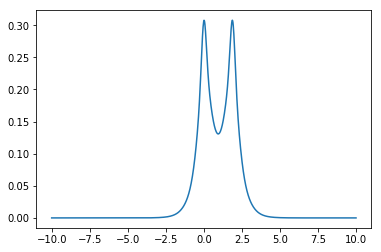

In [77]:
plt.plot(xs, ys)

In [61]:
import scipy.ndimage.filters as scf

In [73]:
p = scf.laplace(ys)

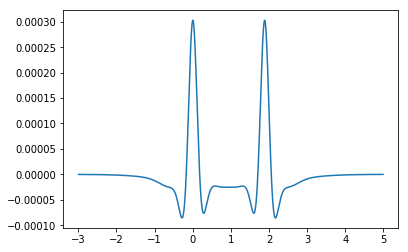

In [74]:
plt.plot(xs[1:-1], -p[1:-1])

In [81]:
def do_1d_epn(xs, den):
    epn = []
    for x in xs:
        d = 1. / np.abs(xs-x)
        d[~np.isfinite(d)] = 0
        epn.append((den * d).sum())
    return epn

In [82]:
epn = do_1d_epn(xs, ys)

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


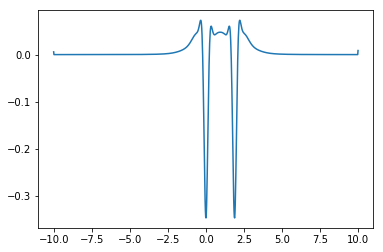

In [84]:
#p = scf.laplace(ys)
plt.plot(xs, scf.laplace(epn))